# Analysis

In [2]:
%load_ext autoreload
%autoreload 2
from utils import dpo_dependencies
from utils import base_dependencies
import random
import pandas as pd
import numpy as np
import shutil
import pandas as pd  
from itertools import combinations
import math

c:\Users\HP\anaconda3\envs\thesis_3_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
annos_raw = dpo_dependencies.collect_annotations("anno")

44867


In [4]:
# % clicking on the left
tmp = annos_raw[~annos_raw['preference'].isna()]
tmp = tmp[tmp['simp_pair_id'].str.contains('r2')]
tmp = tmp[tmp['userID'] != 'ta06']
tmp = tmp[tmp['userID'] != 'ta08']
tmp = tmp[tmp['userID'] != 'ta09']
tmp_ta = tmp[tmp['userID'].str.contains('ta')]
tmp_ea = tmp[tmp['userID'].str.contains('ea')]  
print(tmp_ta['raw_preference'].value_counts(normalize=True))
print(tmp_ea['raw_preference'].value_counts(normalize=True))

Vereinfachung 2    0.635119
Vereinfachung 1    0.364881
Name: raw_preference, dtype: float64
Vereinfachung 2    0.525571
Vereinfachung 1    0.474429
Name: raw_preference, dtype: float64


### Confirm count per file

In [5]:
def count_per_file(df, day):
    if day == '2025-01-29':
        length_set = [129]
    if day == '2025-02-12':
        length_set = [140,235]
    if day == '2025-02-20':
        length_set = [566,482,176,176,477,482,176,477,477,171] # ta01, ta02, ta03, ta04, ta05, ta07, ta10, ta11, ta12, ta13
    if day == '2025-03-10':
        length_set = [793, 838, 402, 221, 392, 208, 412, 430] # ea04, ea03, #ta11, #ta03, #ta14, #ta10, #ta02, #ta05
    if day == '2025-03-11':
        length_set = [686, 883, 737] # ea04, ea01, ea01
    if day == '2025-03-12':
        length_set = [649, 212, 446, 237, 419, 838, 415, 742, 449, 303] #ta14, ta10, ta12, ta04, ea04, ea02, ta11, ea03, ea01
    df = df[df['day'] == pd.to_datetime(day).date()]
    tmp = df.drop_duplicates(subset=['filename', 'simp_pair_id'])
    for filename in list(set(df['filename'])):
        if 'ea' in filename:
            assert len(df[df['filename'] == filename]) in length_set, print(filename, len(df[df['filename'] == filename]))
        else:
            assert len(tmp[tmp['filename'] == filename]) in length_set, print(filename, len(tmp[tmp['filename'] == filename]))
#count_per_file(annos_raw, day='2025-01-29')
#count_per_file(annos_raw, day='2025-02-12')
#count_per_file(annos_raw, day='2025-02-20')
#count_per_file(annos_raw, day='2025-03-10')
#count_per_file(annos_raw, day='2025-03-11')
#count_per_file(annos_raw, day='2025-03-12')

## Investigating duplicates

In [6]:
def show_duplicates(annos_raw, day):
    tmp = annos_raw[annos_raw['day'] == pd.to_datetime(day).date()]
    tmp = tmp[~tmp['raw_preference'].isna()]
    tmp = tmp.sort_values(by=['userID', 'timestamp', 'original', 'raw_simplification1']).drop_duplicates(subset=['userID', 'original', 'raw_simplification1', 'raw_simplification2', 'raw_preference'], keep='last')
    tmp = tmp[tmp.duplicated(subset=['userID', 'original', 'raw_simplification1', 'raw_simplification2'], keep=False)]
    return tmp

In [7]:
show_duplicates(annos_raw, day='2025-01-29').userID.value_counts()

ta01    4
ta09    4
Name: userID, dtype: int64

In [8]:
show_duplicates(annos_raw, day='2025-02-12').userID.value_counts()

ta09    178
ta08     28
ta03      4
ta01      2
Name: userID, dtype: int64

In [9]:
show_duplicates(annos_raw, day='2025-02-19').userID.value_counts()

ta11    12
Name: userID, dtype: int64

In [10]:
show_duplicates(annos_raw, day='2025-03-10').userID.value_counts()

ta11    12
Name: userID, dtype: int64

In [11]:
show_duplicates(annos_raw, day='2025-03-11').userID.value_counts()

ea04    6
ea01    4
Name: userID, dtype: int64

In [12]:
show_duplicates(annos_raw, day='2025-03-12').userID.value_counts()

ta11    8
ea02    4
ea01    2
Name: userID, dtype: int64

In [13]:
show_duplicates(annos_raw, day='2025-03-13').userID.value_counts()

Series([], Name: userID, dtype: int64)

In [14]:
show_duplicates(annos_raw, day='2025-03-17').userID.value_counts()

Series([], Name: userID, dtype: int64)

In [15]:
show_duplicates(annos_raw, day='2025-03-18').userID.value_counts()

Series([], Name: userID, dtype: int64)

In [16]:
show_duplicates(annos_raw, day='2025-03-20').userID.value_counts()

Series([], Name: userID, dtype: int64)

In [17]:
show_duplicates(annos_raw, day='2025-04-03').userID.value_counts()

ta11    2
Name: userID, dtype: int64

In [18]:
def choice_distribution(annos_raw, user, day):
    tmp = annos_raw[(annos_raw['userID'] == user)]
    tmp = tmp[tmp['day'] == pd.to_datetime(day).date()]
    if len(tmp) > 0:
        tmp = tmp[tmp['filename'] == tmp.sort_values(by='filename').iloc[-1]['filename']]
        tmp = tmp[['original', 'raw_preference']]
        vcs = tmp['raw_preference'].value_counts(normalize=True)
        if 'Vereinfachung 1' not in vcs.keys():
            vcs['Vereinfachung 1'] = 0
        return {'userID':user, 'day':day, 'share_left':vcs['Vereinfachung 1']}

print('Proportion of Pairs with Option 1 Preference')
left_shares = []
for day in ['2025-01-29', '2025-02-12', '2025-02-19', '2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-13', '2025-03-15', '2025-03-17', '2025-03-18', '2025-03-20', '2025-03-24', '2025-04-03', '2025-04-04']:
    for user in ['ta01', 'ta02', 'ta03', 'ta04', 'ta05', 'ta06', 'ta07', 'ta08', 'ta09', 'ta10', 'ta11', 'ta12' , 'ta13', 'ta14', 'ta15', 'ea01', 'ea02', 'ea03', 'ea04']:
        left_shares.append(choice_distribution(annos_raw, user, day))
left_shares = [obj for obj in left_shares if obj is not None]
left_shares = pd.DataFrame(left_shares)

Proportion of Pairs with Option 1 Preference


In [19]:
tmp = annos_raw
tmp = tmp[~tmp['preference'].isna()]
tmp1 = tmp[tmp['raw_preference'] == 'Vereinfachung 1']
tmp2 = tmp[tmp['raw_preference'] == 'Vereinfachung 2']
tmp1 = tmp1.groupby(by='userID').count()
tmp2 = tmp2.groupby(by='userID').count()
tmp1 = tmp1.rename(columns={'raw_preference':'left'})
tmp2 = tmp2.rename(columns={'raw_preference':'right'})
tmp1 = tmp1[['left']]
tmp2 = tmp2[['right']]
tmp = pd.concat([tmp1, tmp2], axis=1)
tmp['left_share'] = tmp['left'] / (tmp['left'] + tmp['right'])
tmp

,left,right,left_share
userID,,,
ea01,572,573,0.499563
ea02,485,503,0.490891
ea03,521,519,0.500962
ea04,427,561,0.432186
ta01,468,963,0.327044
ta02,314,737,0.298763
ta03,532,627,0.459016
ta04,215,313,0.407197
ta05,171,590,0.224704


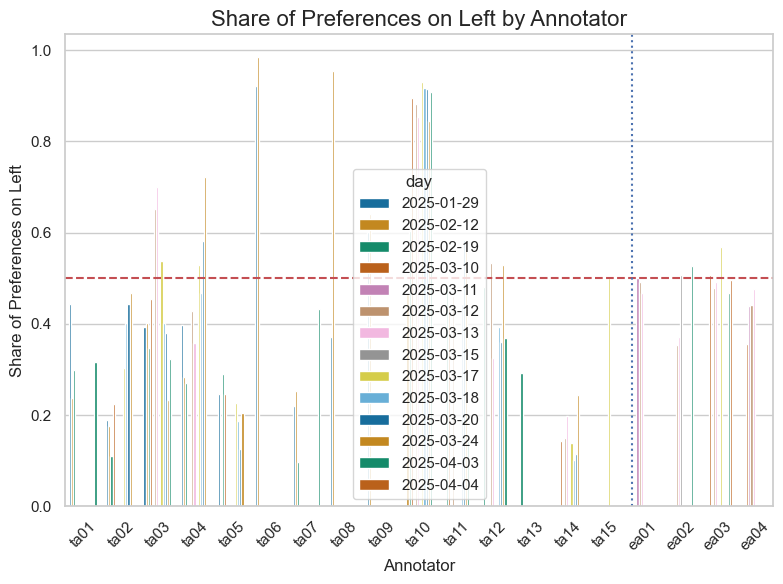

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

user_order = ['ta01', 'ta02', 'ta03', 'ta04', 'ta05', 'ta06', 'ta07', 'ta08', 'ta09', 'ta10', 'ta11', 'ta12' , 'ta13', 'ta14', 'ta15', 'ea01', 'ea02', 'ea03', 'ea04']
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="userID", y="share_left", hue="day", data=left_shares, order=user_order, palette='colorblind')
#ax.legend_.remove()

# Customize the plot
plt.title("Share of Preferences on Left by Annotator", fontsize=16)
plt.xlabel("Annotator", fontsize=12)
plt.ylabel("Share of Preferences on Left", fontsize=12)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=14.7, color='b', linestyle=':')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping


C:\Users\HP\AppData\Local\Temp\ipykernel_19496\1654025724.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = left_shares.groupby("userID", as_index=False).mean()
C:\Users\HP\AppData\Local\Temp\ipykernel_19496\1654025724.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="userID", y="share_left", data=aggregated_data, order=user_order, palette="colorblind")


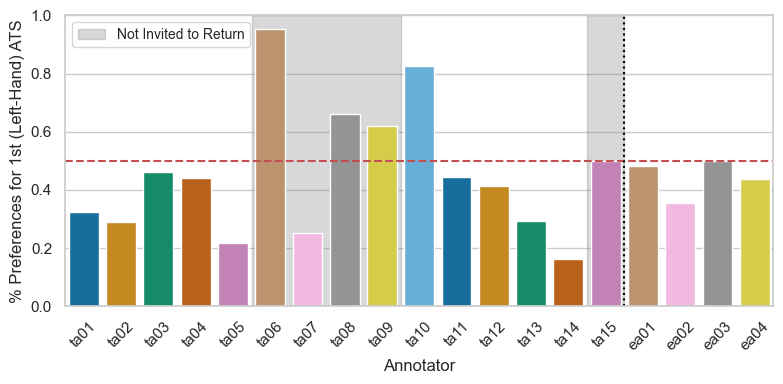

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Aggregate data to combine all days for each annotator
aggregated_data = left_shares.groupby("userID", as_index=False).mean()

# Define the order of annotators
user_order = ['ta01', 'ta02', 'ta03', 'ta04', 'ta05', 'ta06', 'ta07', 'ta08', 'ta09', 'ta10', 'ta11', 'ta12', 
              'ta13', 'ta14', 'ta15', 'ea01', 'ea02', 'ea03', 'ea04']

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

plt.axvspan(5 - 0.5, 8 + 0.5, color='gray', alpha=0.3)
plt.axvspan(14 - 0.5, 14 + 0.5, color='gray', alpha=0.3)

legend_elements = [Patch(facecolor='gray', edgecolor='gray', alpha=0.3, label='Not Invited to Return')]
plt.legend(handles=legend_elements, loc='upper left', fontsize=10)


# Create a barplot with one bar per annotator
ax = sns.barplot(x="userID", y="share_left", data=aggregated_data, order=user_order, palette="colorblind")

# Customize the plot
#plt.title("Average Share of Preferences on Left by Annotator", fontsize=16)
plt.xlabel("Annotator", fontsize=12)
plt.ylabel("% Preferences for 1st (Left-Hand) ATS", fontsize=12)
plt.axhline(y=0.5, color='r', linestyle='--')  # Add a reference line at 0.5
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.axvline(x=14.5, color='black', linestyle=':')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig('figures/prefpair_annoside.png', dpi=800)

In [22]:
# ta09 on Feb 12 changes and maintains afterward: r1_pid_lhapa238309 r2_pid_apa824837
# rest are valid double-sightings (file was repeated after 235 pairs)

# ta08 on Feb 12 are valid double-sightings (file was repeated after 235 pairs)

# ta03 on Feb 12 changes and maintains afterward: r2_pid_apa824837
# rest are valid double-sightings (file was repeated after 235)

# ta01 is a valid double-sighting (file was repeated after 235)

# feb 19
# ta11 has 12 repeats - they hit refresh and restarted due to motor issues

# mar 10
# ta03 has 4 repeats, no clear reason why
# ta11 had several repeats, probably related to motor issues again. 11:08 appears to be the cutoff.

# mar 11
# ea04, ea01 had some IAA data

# mar 12
# ta11 motor issues, 14:00 is cutoff. ea02 had some IAA data, ta03 had two pairs which they changed after first annotation ('r2_pid_apa895395', 'r2_pid_apa895217')

#### Original v Simple Sense Check

ea03    45
ea01    44
ta11    20
ta02    15
ta03    15
ta05    15
ta10    15
ta14    13
ta01    10
ta04    10
ta07    10
ta12    10
Name: userID, dtype: int64
   userID  preference
0    ea01   52.272727
1    ea03   22.222222
2    ta01   50.000000
3    ta02   46.666667
4    ta03   46.666667
5    ta04   70.000000
6    ta05   60.000000
7    ta07   50.000000
8    ta10   60.000000
9    ta11   60.000000
10   ta12   70.000000
11   ta14   30.769231


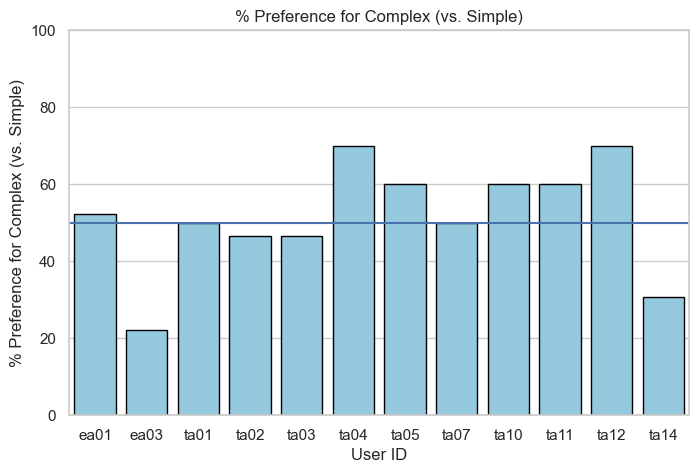

In [23]:
tmp = annos_raw[annos_raw['simp_pair_id'].str.contains('ovs')]
tmp = tmp[~tmp['preference'].isna()]
#tmp = tmp[tmp['info_equality'] == 'y']
tmp = tmp[tmp['day'] >= pd.to_datetime('2025-03-10').date()]
print(tmp['userID'].value_counts())
vereinfachung_1_pct = tmp.groupby('userID')['preference'].apply(lambda x: (x == 'Vereinfachung 1').mean() * 100).reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=vereinfachung_1_pct, x='userID', y='preference', color='skyblue', edgecolor='black')
plt.xlabel('User ID')
plt.ylabel('% Preference for Complex (vs. Simple)')
plt.title('% Preference for Complex (vs. Simple)')
plt.ylim(0, 100)
plt.axhline(50)
plt.xticks(rotation=0)
print(vereinfachung_1_pct)
plt.show()

In [24]:
from scipy.stats import binomtest
for userID in tmp['userID'].unique():
    tmp2 = tmp[tmp['userID'] == userID]
    n = len(tmp2)
    k = len(tmp2[tmp2['preference'] == 'Vereinfachung 1'])
    p = k / n
    print(userID, n, k, p)
    print(binomtest(k, n, p=0.5))

ea01 44 23 0.5227272727272727
BinomTestResult(k=23, n=44, alternative='two-sided', statistic=0.5227272727272727, pvalue=0.880395821280672)
ea03 45 10 0.2222222222222222
BinomTestResult(k=10, n=45, alternative='two-sided', statistic=0.2222222222222222, pvalue=0.00024708778460080794)
ta01 10 5 0.5
BinomTestResult(k=5, n=10, alternative='two-sided', statistic=0.5, pvalue=1.0)
ta02 15 7 0.4666666666666667
BinomTestResult(k=7, n=15, alternative='two-sided', statistic=0.4666666666666667, pvalue=1.0)
ta03 15 7 0.4666666666666667
BinomTestResult(k=7, n=15, alternative='two-sided', statistic=0.4666666666666667, pvalue=1.0)
ta04 10 7 0.7
BinomTestResult(k=7, n=10, alternative='two-sided', statistic=0.7, pvalue=0.34375)
ta05 15 9 0.6
BinomTestResult(k=9, n=15, alternative='two-sided', statistic=0.6, pvalue=0.6072387695312499)
ta07 10 5 0.5
BinomTestResult(k=5, n=10, alternative='two-sided', statistic=0.5, pvalue=1.0)
ta10 15 9 0.6
BinomTestResult(k=9, n=15, alternative='two-sided', statistic=0.6,

### IAA for Expert (same day) and Target (inter-day)

In [34]:
def intra_ta_aa(annos_raw):
    tmp2 = annos_raw.groupby(by=['userID', 'day']).head(60)
    tmp2 = tmp2[tmp2['day'] >= pd.to_datetime('2025-03-20').date()]
    tmp2 = tmp2[~((tmp2['day'] > pd.to_datetime('2025-03-20').date()) & (tmp2['userID'].isin(['ta14', 'ta03'])))]
    tmp2 = tmp2[~tmp2['simp_pair_id'].str.contains('ovs')]
    tmp2 = tmp2[['userID', 'simp_pair_id']]

    tmp = annos_raw[~annos_raw['preference'].isna()]
    #tmp = tmp[tmp['info_equality'] == 'y']
    tmp = tmp[tmp['userID'].str.contains('ta')]
    tmp = tmp[tmp['userID'] != 'ta09']
    tmp = tmp[tmp['userID'] != 'ta06']
    tmp = tmp[tmp['userID'] != 'ta08']
    tmp = pd.merge(tmp, tmp2, how='right', on=['userID', 'simp_pair_id'])
    tmp = tmp[tmp['day'] >= pd.to_datetime('2025-02-12').date()]

    max_timestamps = tmp.groupby(['userID', 'day'])['timestamp'].transform('max')
    tmp = tmp[tmp['timestamp'] == max_timestamps]

    tmp = tmp.sort_values(by=['userID', 'day', 'simp_pair_id']).groupby(by=['userID', 'day', 'simp_pair_id']).tail(1)

    tmp = tmp[tmp.duplicated(subset=['userID', 'simp_pair_id'], keep=False)]

    return tmp.sort_values(by=['userID', 'simp_pair_id'])

def intra_ea_aa(annos_raw):
    tmp = annos_raw[~annos_raw['preference'].isna()]
    #tmp = tmp[tmp['info_equality'] == 'y']
    tmp = tmp[tmp['userID'].str.contains('ea')]
    tmp = tmp[tmp['day'] >= pd.to_datetime('2025-02-12').date()]

    tmp = tmp[tmp.duplicated(subset=['userID', 'simp_pair_id'], keep=False)]

    return tmp

def intra_aa_daydiff(intra_data, userID):
    tmp = intra_data[intra_data['userID'] == userID]
    first_occurence = tmp.sort_values(by=['userID', 'day', 'simp_pair_id']).groupby(by=['userID', 'simp_pair_id']).head(1)
    last_occurence = tmp.sort_values(by=['userID', 'day', 'simp_pair_id']).groupby(by=['userID', 'simp_pair_id']).tail(1)
    first_occurence['userID'] = userID + '0'
    last_occurence['userID'] = userID + '1'
    tmp = pd.concat([first_occurence, last_occurence])
    print(tmp['userID'].value_counts())
    if 'ta' in userID:
        tmp = tmp.drop_duplicates(['day', 'simp_pair_id'], keep=False)
    return dpo_dependencies.inter_annotator_agreement(tmp, detail=False, ret=True)

intra_ta_data = intra_ta_aa(annos_raw[annos_raw['day'] != pd.to_datetime('2025-03-13').date()])
iaas_ta = {}
for userID in intra_ta_data['userID'].unique():
    iaas_ta[userID] = intra_aa_daydiff(intra_ta_data, userID)

intra_ea_data = intra_ea_aa(annos_raw) #[annos_raw['day'] < pd.to_datetime('2025-03-13').date()])
print(intra_ea_data['userID'].value_counts())
iaas_ea = {}
for userID in intra_ea_data['userID'].unique():
    iaas_ea[userID] = intra_aa_daydiff(intra_ea_data, userID)

iaas = {**iaas_ta, **iaas_ea}
top_four_itra_ta = sorted([(k, v) for k, v in iaas.items() if 'ta' in k and not math.isnan(v[0])], key=lambda x: x[1][0], reverse=True)[0:4]
top_four_itra_ta = [tmp[0] for tmp in top_four_itra_ta]
top_two_itra_ea = sorted([(k, v) for k, v in iaas.items() if 'ea' in k and not math.isnan(v[0])], key=lambda x: x[1][0], reverse=True)[0:2]
top_two_itra_ea = [tmp[0] for tmp in top_two_itra_ea]
top_four_itra_ta, top_two_itra_ea

ta010    50
ta011    50
Name: userID, dtype: int64
('ta010', 'ta011'): -0.019 (50 obs)
ta020    50
ta021    50
Name: userID, dtype: int64
('ta020', 'ta021'): 0.040 (50 obs)
ta030    41
ta031    41
Name: userID, dtype: int64
('ta030', 'ta031'): -0.026 (41 obs)
ta040    50
ta041    50
Name: userID, dtype: int64
('ta040', 'ta041'): 0.168 (50 obs)
ta050    50
ta051    50
Name: userID, dtype: int64
('ta050', 'ta051'): 0.300 (50 obs)
ta070    41
ta071    41
Name: userID, dtype: int64
('ta070', 'ta071'): -0.045 (41 obs)
ta100    50
ta101    50
Name: userID, dtype: int64
('ta100', 'ta101'): 0.065 (50 obs)
ta110    32
ta111    32
Name: userID, dtype: int64
('ta110', 'ta111'): 0.062 (32 obs)
ta120    50
ta121    50
Name: userID, dtype: int64
('ta120', 'ta121'): 0.155 (50 obs)
ta140    44
ta141    44
Name: userID, dtype: int64
('ta140', 'ta141'): 0.008 (44 obs)
ea01    114
ea03     94
ea02     90
ea04     90
Name: userID, dtype: int64
ea010    57
ea011    57
Name: userID, dtype: int64
('ea010', '

(['ta05', 'ta04', 'ta12', 'ta10'], ['ea02', 'ea03'])

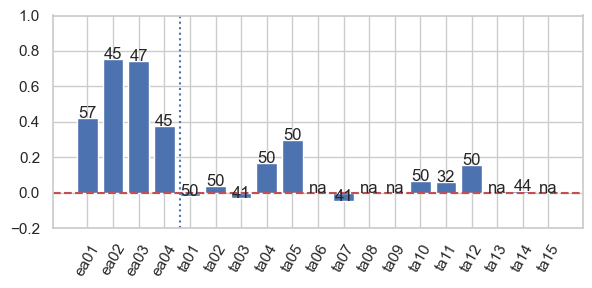

In [35]:
import matplotlib.pyplot as plt
iaas = {**iaas_ta, **iaas_ea}
iaas_w_missings = iaas
for i in range(15):
    i_str = str(i+1)
    if len(i_str) < 2:
        i_str = 'ta0' + i_str
    else:
        i_str = 'ta' + i_str
    if i_str not in iaas_w_missings.keys():
        iaas_w_missings[i_str] = (0, 'na')

iaas_w_missings = {key: value for key, value in sorted(iaas_w_missings.items())}

labels, values = zip(*[(k, v[0]) for k, v in iaas_w_missings.items()])
annotations = [v[1] for v in iaas_w_missings.values()]
plt.figure(figsize=(6, 3))
plt.bar(labels, values)
for i, txt in enumerate(annotations):
    plt.text(i, values[i] + 0, txt, ha='center')

plt.axvline(x=3.6, color='b', linestyle=':')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=60)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.ylim(-.2,1)
plt.show()


In [36]:
iaas

{'ta01': (-0.01880877742946696, 50),
 'ta02': (0.03982930298719767, 50),
 'ta03': (-0.026221692491060766, 41),
 'ta04': (0.16805324459234605, 50),
 'ta05': (0.29983525535420097, 50),
 'ta07': (-0.04458598726114649, 41),
 'ta10': (0.06504065040650409, 50),
 'ta11': (0.0625, 32),
 'ta12': (0.15458937198067635, 50),
 'ta14': (0.007843137254901933, 44),
 'ea01': (0.41984732824427473, 57),
 'ea02': (0.7551686615886833, 45),
 'ea03': (0.7450271247739602, 47),
 'ea04': (0.37623762376237624, 45),
 'ta06': (0, 'na'),
 'ta08': (0, 'na'),
 'ta09': (0, 'na'),
 'ta13': (0, 'na'),
 'ta15': (0, 'na')}

### Same-day IAA

In [37]:
def explore_user(annos_raw, user, day):

    print("\n")
    print(day)

    if day != 'inter':
        tmp = annos_raw[annos_raw['day'] == pd.to_datetime(day).date()]

    # on 1.29, pre 11:03:46 submissions and ta11 submissions are valid, disparate sets by ta09
    if day == "2025-01-29":
        tmp[~tmp['preference'].isna()]
        tmp = tmp.sort_values(by=['userID', 'timestamp', 'original', 'simplification1']).drop_duplicates(subset=['userID', 'original', 'simp_pair_id', 'filename'], keep='last')
        cutoff_time = pd.Timestamp(f'{day} 11:03:46')  
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] <= cutoff_time), 'userID'] = user + '0'  
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] > cutoff_time), 'userID'] = user + '1'  
        tmp.loc[(tmp['userID'] == user + '1') & (tmp['filename'].str.contains('ta11')), 'userID'] = user + '2' 
        tmp = tmp[(tmp['userID'] == user + '0') | (tmp['userID'] == user + '1') | (tmp['userID'] == user + '2')]
        tmp = tmp.drop_duplicates(subset=['userID', 'original', 'simp_pair_id'], keep='last')
    # on 2.12, first version of duplicate in last submission and second version of duplicate in last submission are valid, disparate sets by ta09
    if day == "2025-02-12":
        tmp = annos_raw[(annos_raw['userID'] == user)]
        tmp = annos_raw[(annos_raw['userID'] == user) & (annos_raw['timestamp'] == tmp.sort_values(by='timestamp').iloc[-1]['timestamp'])]
        if user == 'ta03':
            count = 140
        else:
            count = 235
        tmp1 = tmp.copy()[0:count]
        tmp2 = tmp.copy()[count:]
        print(len(tmp1), len(tmp2))
        tmp1['userID'] = user + '3'
        tmp2['userID'] = user + '4'
        tmp = pd.concat([tmp1, tmp2])
        tmp = tmp[~tmp['preference'].isna()]
    # on 2.19, ta11 refreshed twice. the first refresh happens right after the 13:25:27 submission
    if day == "2025-02-19":
        tmp = annos_raw[(annos_raw['userID'] == user)]
        tmp = tmp[~tmp['preference'].isna()]
        cutoff_time = pd.Timestamp(f'{day} 13:25:28')
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] <= cutoff_time), 'userID'] = user + '0'  
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] > cutoff_time), 'userID'] = user + '1'
        #tmp = tmp.drop_duplicates(subset=['userID', 'original', 'simp_pair_id', 'preference'], keep='last')  
        #print(len(tmp[tmp['userID'] == 'ta111']), len(tmp[tmp['userID'] == 'ta111']['simp_pair_id'].unique()))
        tmp = tmp.drop_duplicates(subset=['userID', 'original', 'simp_pair_id'], keep='last')
    if day == "2025-03-10":
        tmp = annos_raw[(annos_raw['userID'] == user)]
        tmp = tmp[~tmp['preference'].isna()]
        cutoff_time = pd.Timestamp(f'{day} 11:08:00')
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] <= cutoff_time), 'userID'] = user + '0'  
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] > cutoff_time), 'userID'] = user + '1'
        #tmp = tmp.drop_duplicates(subset=['userID', 'original', 'simp_pair_id', 'preference'], keep='last')  
        #print(len(tmp[tmp['userID'] == 'ta111']), len(tmp[tmp['userID'] == 'ta111']['simp_pair_id'].unique()))
        tmp = tmp.drop_duplicates(subset=['userID', 'original', 'simp_pair_id'], keep='last')
    if day == "2025-03-12":
        tmp = annos_raw[(annos_raw['userID'] == user)]
        tmp = tmp[~tmp['preference'].isna()]
        cutoff_time = pd.Timestamp(f'{day} 14:00:00')
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] <= cutoff_time), 'userID'] = user + '0'  
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] > cutoff_time), 'userID'] = user + '1'
        #tmp = tmp.drop_duplicates(subset=['userID', 'original', 'simp_pair_id', 'preference'], keep='last')  
        #print(len(tmp[tmp['userID'] == 'ta111']), len(tmp[tmp['userID'] == 'ta111']['simp_pair_id'].unique()))
        tmp = tmp.drop_duplicates(subset=['userID', 'original', 'simp_pair_id'], keep='last')
    if day == "inter":
        tmp = annos_raw[(annos_raw['userID'] == user)]
        tmp = tmp[~tmp['preference'].isna()]
        tmp = tmp[tmp['day'] >= pd.to_datetime('2025-02-12').date()]

        max_timestamps = tmp.groupby(['userID', 'day'])['timestamp'].transform('max')
        tmp = tmp[tmp['timestamp'] == max_timestamps]
        tmp = tmp.sort_values(by=['userID', 'day', 'simp_pair_id']).groupby(by=['userID', 'day', 'simp_pair_id']).tail(1)

        cutoff_time = pd.Timestamp('2025-02-15 13:25:28')
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] <= cutoff_time), 'userID'] = user + '0'  
        tmp.loc[(tmp['userID'] == user) & (tmp['timestamp'] > cutoff_time), 'userID'] = user + '1'

        tmp = tmp.drop_duplicates(subset=['userID', 'original', 'simp_pair_id'], keep='last')

    return tmp.sort_values(by=['userID', 'simp_pair_id'])


#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta09', day='2025-01-29'))
#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta09', day='2025-02-12'))
#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta08', day='2025-02-12'))
#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta03', day='2025-02-12'))
#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta01', day='2025-02-12'))
dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta11', day='2025-02-19'))
dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta11', day='2025-03-10'))
dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta11', day='2025-03-12'))

#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta01', day='inter'))
#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta02', day='inter'))
#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta03', day='inter'))
#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta04', day='inter'))
#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta07', day='inter'))
#dpo_dependencies.inter_annotator_agreement(explore_user(annos_raw, user='ta10', day='inter'))



2025-02-19
Pairs annotated by user:
ta111: 168 / 168
ta110: 23 / 23
191 total

IAA (Cohen's Kappa, pairwise):
('ta110', 'ta111'): 0.303 (23 obs)


2025-03-10
Pairs annotated by user:
ta111: 153 / 153
ta110: 44 / 44
197 total

IAA (Cohen's Kappa, pairwise):
('ta110', 'ta111'): 0.249 (29 obs)


2025-03-12
Pairs annotated by user:
ta111: 120 / 120
ta110: 90 / 90
210 total

IAA (Cohen's Kappa, pairwise):
('ta110', 'ta111'): 0.048 (42 obs)


### Inter-Annotation Agreement

#### Group: Krippendorf's

In [38]:
import numpy as np
import krippendorff

from statsmodels.stats import inter_rater as irr

import pandas as pd
import numpy as np
import itertools

created_pairs = pd.read_json('outputs/dpo/pair_creation/all_created_pairs.jsonl', lines=True)
created_pairs = created_pairs[['model', 'original', 'prompt', 'simp_pair_id']]
clean_preference_data = pd.merge(annos_raw, created_pairs, how='left', on=['simp_pair_id','original'], indicator=True)

def inter_aa(all_winning_pairs, annos_raw, ta_or_ea, inter_size, info_equality = True, intra_target = False, filter_date = '2025-02-12', model = ''):

    created_pairs = pd.read_json('outputs/dpo/pair_creation/all_created_pairs.jsonl', lines=True)
    created_pairs = created_pairs[['model', 'original', 'simp_pair_id']]
    annos_raw = pd.merge(annos_raw, created_pairs, how='left', on=['simp_pair_id','original'], indicator=True)

    if model != '':
        annos_raw = annos_raw[annos_raw['model'] == model]

    annos_raw = annos_raw[annos_raw['userID'] != 'ta09']
    annos_raw = annos_raw[annos_raw['userID'] != 'ta06']
    annos_raw = annos_raw[annos_raw['userID'] != 'ta08']
    annos_raw = annos_raw[annos_raw['day'] >= pd.to_datetime(filter_date).date()] # '2025-03-20'
    annos_raw = annos_raw[~annos_raw['day'].isna()]
    annos_raw = annos_raw[~annos_raw['preference'].isna()]

    # filter to cohort under consideration
    if 't' in ta_or_ea:
        annos_raw = annos_raw[annos_raw['userID'].str.contains('ta')]
    else:
        annos_raw = annos_raw[annos_raw['userID'].str.contains('ea')]

    # filter based on info equality if necessary
    if info_equality == True:
        all_winning_pairs = all_winning_pairs[all_winning_pairs['info_equality'] == 'y']
    all_winning_pairs = all_winning_pairs[all_winning_pairs['simp_pair_id'].str.contains('r2_')]
    legal_pairs = list(all_winning_pairs['simp_pair_id'].unique())

    # remove ones with negative intra-AA
    users = annos_raw['userID'].unique()

    if intra_target == True:
        for user in users:
            if (user in iaas.keys()) and (iaas[user][0] >= 0.05):
                pass
            else:
                annos_raw = annos_raw[annos_raw['userID'] != user]

    # acquire pairs with crossover
    tmp2 = annos_raw[annos_raw['simp_pair_id'].isin(legal_pairs)]
    tmp2 = tmp2.drop_duplicates(subset=['userID', 'simp_pair_id'], keep='last')
    pairs_w_crossover = list(tmp2[tmp2.duplicated(subset=['simp_pair_id'], keep=False)]['simp_pair_id'].unique())
    legal_pairs_w_crossover = [pwc for pwc in pairs_w_crossover if pwc in legal_pairs]
    #print(len(legal_pairs_w_crossover), pairs_w_crossover)

    # acquire the inter data
    tmp = annos_raw[annos_raw['simp_pair_id'].isin(legal_pairs_w_crossover)]
    tmp = tmp[~tmp['preference'].isna()]
    tmp = tmp.sort_values(by=['userID', 'simp_pair_id', 'timestamp'])
    tmp = tmp.drop_duplicates(subset=['userID', 'simp_pair_id'], keep='last')
    #tmp = tmp[['userID', 'simp_pair_id', 'preference', 'original', 'simplification1', 'simplification2']]
    tmp['pref'] = tmp['preference'].str[-1:].astype(int)
    tmp = tmp.sort_values(by=['simp_pair_id', 'userID'])[['userID', 'simp_pair_id', 'pref']]
    spid_vcs = tmp['simp_pair_id'].value_counts()
    spids = spid_vcs[spid_vcs > 3]
    tmp = tmp[tmp['simp_pair_id'].isin(spids.index)]
    #print(tmp['userID'].value_counts())
    user_ids = tmp['userID'].unique()
    #print(user_ids)
    if '2' not in ta_or_ea:
        if len(user_ids) != inter_size:
            inter_size = len(user_ids)

    # Iterate over combinations of userIDs of size 3 and larger
    best = -1
    best_user_set = []
    best_shared_pair_count = 0
    for size in [inter_size]: #range(2, len(user_ids) + 1):
        for user_combination in itertools.combinations(user_ids, size):
            #if ta_or_ea == 'ea':
                #print(user_combination)
            tmp_combination = tmp[tmp['userID'].isin(user_combination)]

            users = sorted(tmp_combination['userID'].unique())
            pairs = sorted(tmp_combination['simp_pair_id'].unique())

            user_index = {user: i for i, user in enumerate(users)}
            pair_index = {pair: i for i, pair in enumerate(pairs)}

            matrix = np.full((len(users), len(pairs)), np.nan)

            for _, row in tmp_combination.iterrows():
                u_idx = user_index[row['userID']]
                p_idx = pair_index[row['simp_pair_id']]
                matrix[u_idx, p_idx] = row['pref']

            data_for_krippendorf = matrix.tolist()

            krippendorff_alpha_nominal = krippendorff.alpha(reliability_data=data_for_krippendorf, level_of_measurement="nominal")

            if krippendorff_alpha_nominal > best:
                best = krippendorff_alpha_nominal
                best_user_set = user_combination
                best_shared_pair_count = len(list(tmp_combination['simp_pair_id'].unique()))
            #if (krippendorff_alpha_nominal > 0.5) or (len(user_combination) == inter_size):
                #print(str(krippendorff_alpha_nominal)[0:5], str(len(user_combination)) + ' users', str(len(list(tmp_combination['simp_pair_id'].unique()))) + ' shaired pairs')

    print(filter_date, info_equality, intra_target, ":", best, best_user_set, best_shared_pair_count)
    return best_user_set

all_winning_pairs = pd.read_json('outputs/dpo/pair_creation/all_created_pairs.jsonl', lines=True)
top_four_iter_ta = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ta', inter_size = 11, info_equality = False, intra_target = False, filter_date = '2025-02-12')
_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ta', inter_size = 11, info_equality = False, intra_target = False, filter_date = '2025-02-12', model = 'Disco Llama8B')
_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ta', inter_size = 11, info_equality = False, intra_target = False, filter_date = '2025-02-12', model = 'Llama8B')
_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ta', inter_size = 11, info_equality = False, intra_target = False, filter_date = '2025-02-12', model = 'LeoLM Mistral 7B')
#_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ta', inter_size = 12, info_equality = False, intra_target = True, filter_date = '2025-02-12')
#_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ta', inter_size = 12, info_equality = True, intra_target = True, filter_date = '2025-02-12')
#_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ta', inter_size = 8, info_equality = False, intra_target = False, filter_date = '2025-03-20')
#_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ta', inter_size = 8, info_equality = False, intra_target = True, filter_date = '2025-03-20')
#_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ta', inter_size = 8, info_equality = True, intra_target = True, filter_date = '2025-03-20')
top_four_iter_ta = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='t2', inter_size = 4, info_equality=False, intra_target=False, filter_date = '2025-02-12')

top_two_iter_ea = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ea', inter_size = 4, info_equality = False, intra_target = False, filter_date = '2025-02-12')
_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ea', inter_size = 4, info_equality = False, intra_target = False, filter_date = '2025-02-12', model = 'Disco Llama8B')
_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ea', inter_size = 4, info_equality = False, intra_target = False, filter_date = '2025-02-12', model = 'Llama8B')
_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ea', inter_size = 4, info_equality = False, intra_target = False, filter_date = '2025-02-12', model = 'LeoLM Mistral 7B')

#_ = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='ea', inter_size = 4, info_equality = True, intra_target = False, filter_date = '2025-02-12')

top_two_iter_ea = inter_aa(all_winning_pairs, annos_raw, ta_or_ea='e2', inter_size = 2, info_equality = False, intra_target = False, filter_date = '2025-02-12')

#top_four_iter_ta, top_two_iter_ea
# krippendorfs

2025-02-12 False False : -0.0037622294262160683 ('ta01', 'ta02', 'ta03', 'ta04', 'ta05', 'ta07', 'ta10', 'ta11', 'ta12', 'ta14', 'ta13') 105
2025-02-12 False False : -0.001747688060731667 ('ta01', 'ta02', 'ta03', 'ta04', 'ta05', 'ta07', 'ta10', 'ta12', 'ta14', 'ta11', 'ta13') 44
2025-02-12 False False : -0.014421324085189813 ('ta01', 'ta02', 'ta03', 'ta04', 'ta05', 'ta07', 'ta10', 'ta11', 'ta12', 'ta14', 'ta13') 33
2025-02-12 False False : 0.014166129538731309 ('ta01', 'ta02', 'ta03', 'ta04', 'ta05', 'ta07', 'ta10', 'ta11', 'ta12', 'ta14', 'ta13') 28
2025-02-12 False False : 0.2140151515151515 ('ta03', 'ta05', 'ta07', 'ta12') 93
2025-02-12 False False : 0.35715170278637776 ('ea01', 'ea02', 'ea03', 'ea04') 45
2025-02-12 False False : 0.32380952380952377 ('ea01', 'ea02', 'ea03', 'ea04') 18
2025-02-12 False False : 0.24786324786324787 ('ea01', 'ea02', 'ea03', 'ea04') 14
2025-02-12 False False : 0.5363636363636364 ('ea01', 'ea02', 'ea03', 'ea04') 13
2025-02-12 False False : 0.5602766798418

In [39]:
top_two_iter_ea, top_two_itra_ea, top_four_iter_ta, top_four_itra_ta

(('ea01', 'ea02'),
 ['ea02', 'ea03'],
 ('ta03', 'ta05', 'ta07', 'ta12'),
 ['ta05', 'ta04', 'ta12', 'ta10'])

### Final Set(s)

In [ ]:
def resolve_preference(group):
    mode_values = group['preference'].mode()
    if len(mode_values) == 1:
        chosen_pref = mode_values.iloc[0]
    else:
        chosen_pref = group.loc[group['iaas_value'].idxmax(), 'preference']
    group = group.iloc[:1]
    group['preference'] = chosen_pref
    return group


def process_intersections(df, iaas, userGroup):
    inters = df[df.duplicated(subset=['simp_pair_id'], keep=False)]
    #sids = inters['simp_pair_id'].value_counts()
    #sids = sids[sids > 2]
    #sids = set(sids.index)
    #inters = inters[inters['simp_pair_id'].isin(sids)]

    inters = inters.copy()
    inters.loc[:, "iaas_value"] = inters["userID"].map(lambda user: iaas.get(user, (0, None))[0])

    inters = inters.sort_values(by=["simp_pair_id", "iaas_value"], ascending=[True, False])
    inters = inters.groupby("simp_pair_id", as_index=False).apply(resolve_preference).reset_index(drop=True)
    inters['userID'] = 'inter_'+userGroup
    return pd.concat([df[~df['simp_pair_id'].duplicated(keep=False)], inters])

def intersections_onward(annos_clean):
    ## settle on inter
    ### first, drop inter annotations from people with negative intra-AA if someone with non-negative intra-AA has annotated the same pair
    ta_rows = annos_clean[annos_clean['userID'].str.contains('ta', na=False)]
    lowest_iaa_users = sorted(iaas, key=lambda uid: iaas.get(uid, (0, 0))[0])[:3]
    valid_simp_pairs = set(ta_rows[~ta_rows['userID'].isin(lowest_iaa_users)]['simp_pair_id'])
    ta_rows = ta_rows[~((ta_rows['userID'].isin(lowest_iaa_users)) & (ta_rows['simp_pair_id'].isin(valid_simp_pairs)))]
    ea_rows = annos_clean[annos_clean['userID'].str.contains('ea', na=False)]
    ### second, take modal value for inter pairs
    ta_processed = process_intersections(ta_rows, iaas, 'ta')
    ea_processed = process_intersections(ea_rows, iaas, 'ea')
    ta_processed['userGroup'] = 'ta'
    ea_processed['userGroup'] = 'ea'
    annos_clean = pd.concat([ta_processed, ea_processed])

    print(len(annos_clean), len(ta_processed), len(ea_processed))

    # add in prompt info, format as trl preference dataset
    created_pairs = pd.read_json('outputs/dpo/pair_creation/all_created_pairs.jsonl', lines=True)
    created_pairs = created_pairs[['model', 'original', 'prompt', 'simp_pair_id']]
    clean_preference_data = pd.merge(annos_clean, created_pairs, how='left', on=['simp_pair_id','original'], indicator=True)
    clean_preference_data = clean_preference_data[['prompt', 'original', 'simplification1', 'simplification2', 'preference', 'model', 'simp_pair_id', 'userID', 'userGroup', 'info_equality', 'issue']]
    pref1 = clean_preference_data[clean_preference_data['preference'] == 'Vereinfachung 1']
    pref2 = clean_preference_data[clean_preference_data['preference'] == 'Vereinfachung 2']
    pref1 = pref1.rename(columns={'simplification1':'chosen', 'simplification2':'rejected'})
    pref2 = pref2.rename(columns={'simplification1':'rejected', 'simplification2':'chosen'})
    clean_preference_data = pd.concat([pref1, pref2])[['simp_pair_id', 'model', 'prompt', 'original', 'chosen', 'rejected', 'userID', 'userGroup', 'info_equality', 'issue']]
    clean_preference_data = clean_preference_data.sample(frac=1, random_state = 5)

    # remove identified issue pairs
    clean_preference_data = clean_preference_data[clean_preference_data['issue'] != 'y']

    return clean_preference_data

# collect everything
annos_raw = dpo_dependencies.collect_annotations("anno")
## keep preferences only
annos_clean = annos_raw[~annos_raw['preference'].isna()]
## keep preferences from february sessions onward
annos_clean = annos_clean[annos_clean['day'] > pd.to_datetime('2025-01-29').date()]
## remove problem users
annos_clean = annos_clean[annos_clean['userID'] != 'ta09']
annos_clean = annos_clean[annos_clean['userID'] != 'ta06']
annos_clean = annos_clean[annos_clean['userID'] != 'ta08']
## remove ovs
annos_clean = annos_clean[~annos_clean['simp_pair_id'].str.contains('ovs')]
## remove intra (latest only)
annos_clean['index'] = annos_clean.index
max_timestamps = annos_clean.groupby(['userID', 'day'])['timestamp'].transform('max')
annos_pclean = annos_clean[annos_clean['timestamp'] == max_timestamps]
annos_clean = annos_clean.sort_values(by=['userID', 'simp_pair_id', 'timestamp', 'index']).groupby(by=['userID', 'simp_pair_id']).tail(1)
annos_clean = annos_clean.drop(columns=['index']).reset_index(drop=True)
## keep pairs created by team only
annos_clean['round'] = annos_clean['simp_pair_id'].str.split('_').str.get(0)
annos_clean = annos_clean[annos_clean['round'] == 'r2']
## de-dup intersections, format as trl preference dataset, remove pairs with issues
print(annos_clean['userID'].value_counts())
clean_preference_data = intersections_onward(annos_clean)
print(len(clean_preference_data), len(clean_preference_data[clean_preference_data['userGroup'] == 'ta']), len(clean_preference_data[clean_preference_data['userGroup'] == 'ea']))
print(clean_preference_data['userID'].value_counts())
#### Save most preference sets

## all data
clean_preference_data.to_json('data/preferences_all.jsonl', orient='records', lines=True)
print('all data: ', len(clean_preference_data)/2)

## info equality
a = clean_preference_data[clean_preference_data['info_equality'] == 'y']
a.to_json('data/preferences_ie.jsonl', orient='records', lines=True)
print('info_equality: ', len(a)/2)

## human + synthetic

## model-specific
b = clean_preference_data[clean_preference_data['model'] == 'Llama8B']
c = clean_preference_data[clean_preference_data['model'] == 'Disco Llama8B']
d = clean_preference_data[clean_preference_data['model'] == 'LeoLM Mistral 7B']
b.to_json('data/preferences_sft_llama8b_checkpoint2400.jsonl', orient='records', lines=True)
c.to_json('data/preferences_sft_disco_llama8b_checkpoint2800.jsonl', orient='records', lines=True)
d.to_json('data/preferences_sft_leolm_mistral7b_checkpoint1600.jsonl', orient='records', lines=True)
print('llama: ', len(b)/2, 'disco llama: ', len(c)/2, 'mistral: ', len(d)/2)

#### Save remaining preference sets (requires us to recreate clean_preference_data based on user set being considered)

## max intraAA
e = intersections_onward(annos_clean[annos_clean['userID'].isin(top_four_itra_ta) | annos_clean['userID'].isin(top_two_itra_ea)])
e.to_json('data/preferences_itra.jsonl', orient='records', lines=True)
print('intra ta: ', len(e[e['userGroup'] == 'ta']), 'intra ea: ', len(e[e['userGroup'] == 'ea']))

## max interAA
f = intersections_onward(annos_clean[annos_clean['userID'].isin(top_four_iter_ta) | annos_clean['userID'].isin(top_two_iter_ea)])
f.to_json('data/preferences_iter.jsonl', orient='records', lines=True)
print('inter ta: ', len(f[f['userGroup'] == 'ta']), 'inter ea: ', len(f[f['userGroup'] == 'ea']))


44867
ta02    857
ea03    798
ea01    794
ea02    793
ea04    793
ta14    761
ta03    755
ta01    691
ta10    452
ta05    431
ta12    333
ta04    211
ta07    173
ta13    171
ta11    137
ta15     78
Name: userID, dtype: int64


NameError: name 'iaas' is not defined

In [25]:
# preferences_raw.jsonl
## version of preferences with all annotation-stage data, including problematic pairs, evaluation pairs, and ovs pairs

# collect everything
annos_raw = dpo_dependencies.collect_annotations("anno")
## keep preferences only
annos_clean = annos_raw[~annos_raw['preference'].isna()]

# deduplicate intra annotations (latest only)
annos_clean['index'] = annos_clean.index
max_timestamps = annos_clean.groupby(['userID', 'day'])['timestamp'].transform('max')
annos_pclean = annos_clean[annos_clean['timestamp'] == max_timestamps]
annos_clean = annos_clean.sort_values(by=['userID', 'simp_pair_id', 'timestamp', 'index']).groupby(by=['userID', 'simp_pair_id']).tail(1)
annos_clean = annos_clean.drop(columns=['index']).reset_index(drop=True)

# list reasons for exclusion from final preference set
annos_clean['exclusion_reason'] = ''
annos_clean.loc[annos_clean['userID'].isin(['ta06', 'ta08', 'ta09']), 'exclusion_reason'] = 'annotator later excluded'
annos_clean.loc[annos_clean['simp_pair_id'].str.contains('ovs', na=False), 'exclusion_reason'] = 'orig-v-simp sense check'
annos_clean.loc[annos_clean['day'] < pd.to_datetime('2025-01-29'), 'exclusion_reason'] = 'pilot session data'
annos_clean['round'] = annos_clean['simp_pair_id'].str.split('_').str.get(0)
annos_clean.loc[annos_clean['round'] == 'r1', 'exclusion_reason'] = 'pair created before standardized creation process'
annos_clean.loc[annos_clean['round'] == 'r3', 'exclusion_reason'] = 'post-DPO eval pair'

# add in prompt info, format as trl preference dataset
created_pairs = pd.read_json('outputs/dpo/pair_creation/all_created_pairs.jsonl', lines=True)
created_pairs = created_pairs[['model', 'original', 'prompt', 'simp_pair_id']]
eval_pairs_w_metadata = pd.read_json('outputs/dpo/dpo_final_pairs/eval_pairs_w_metadata.jsonl', lines=True)
eval_pairs_w_metadata = eval_pairs_w_metadata[['prompt', 'original', 'group_1', 'group_2', 'simp_pair_id', 'backbone']]
eval_pairs_w_metadata = eval_pairs_w_metadata.rename(columns={'backbone': 'model'})
created_pairs = pd.concat([created_pairs, eval_pairs_w_metadata], ignore_index=True)
created_pairs['dpo_inference'] = 'neither'
created_pairs.loc[created_pairs['group_1'].str.contains('dpo', na=False), 'dpo_inference'] = 'simplification1'
created_pairs.loc[created_pairs['group_2'].str.contains('dpo', na=False), 'dpo_inference'] = 'simplification2'
clean_preference_data = pd.merge(annos_clean, created_pairs, how='left', on=['simp_pair_id','original'], indicator=True)
clean_preference_data['userGroup'] = 'ta'
clean_preference_data.loc[clean_preference_data['userID'].str.contains('ea'), 'userGroup'] = 'ea'
clean_preference_data = clean_preference_data[['prompt', 'original', 'simplification1', 'simplification2', 'preference', 'model', 'simp_pair_id', 'userID', 'userGroup', 'info_equality', 'issue', 'dpo_inference', 'exclusion_reason']]
pref1 = clean_preference_data[clean_preference_data['preference'] == 'Vereinfachung 1']
pref2 = clean_preference_data[clean_preference_data['preference'] == 'Vereinfachung 2']
pref1 = pref1.rename(columns={'simplification1':'chosen', 'simplification2':'rejected'})
pref1.loc[pref1['dpo_inference'] == 'simplification1', 'dpo_inference'] = 'chosen'
pref1.loc[pref1['dpo_inference'] == 'simplification2', 'dpo_inference'] = 'rejected'
pref2 = pref2.rename(columns={'simplification1':'rejected', 'simplification2':'chosen'})
pref2.loc[pref2['dpo_inference'] == 'simplification2', 'dpo_inference'] = 'chosen'
pref2.loc[pref2['dpo_inference'] == 'simplification1', 'dpo_inference'] = 'rejected'

clean_preference_data = pd.concat([pref1, pref2])[['simp_pair_id', 'model', 'prompt', 'original', 'chosen', 'rejected', 'userID', 'userGroup', 'info_equality', 'issue', 'exclusion_reason', 'dpo_inference']]
clean_preference_data = clean_preference_data.sample(frac=1, random_state = 5)

clean_preference_data.loc[clean_preference_data['issue'] == 'y', 'exclusion_reason'] = 'language issue'
clean_preference_data.rename(columns={'issue': 'language_issue'}, inplace=True)

clean_preference_data = clean_preference_data.replace('', np.nan)
clean_preference_data = clean_preference_data[~clean_preference_data['chosen'].isna()]
clean_preference_data.to_json('data/preferences_raw.jsonl', orient='records', lines=True)

44867


C:\Users\HP\AppData\Local\Temp\ipykernel_14044\1252820410.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annos_clean['index'] = annos_clean.index
C:\Users\HP\AppData\Local\Temp\ipykernel_14044\1252820410.py:20: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  annos_clean.loc[annos_clean['day'] < pd.to_datetime('2025-01-29'), 'exclusion_reason'] = 'pilot session data'


In [24]:
tmp = clean_preference_data
tmp = tmp.replace('', np.nan)
tmp[tmp['exclusion_reason'].isna()]

,simp_pair_id,model,prompt,original,chosen,rejected,userID,userGroup,info_equality,language_issue,exclusion_reason,dpo_inference
1298,r2_pid_apa1518391,Llama8B,Schreibe den folgenden komplexen Satz um und v...,Seit knapp 2 Jahren gibt es keine neuen 500-Eu...,Seit 2 Jahren gibt es den 500-Euro-Schein nich...,Schon fast 2 Jahre gibt es keine 500-Euro-Sche...,ea02,ea,y,n,NaN,neither
5540,r2_pid_apa1468094,Llama8B,Schreibe den folgenden komplexen Satz in Leich...,"Ein Mammut war ein großes Tier, das aussah wie...",Ein Mammut war ein großes Tier mit dickem Fell...,Ein Mammut sah ähnlich aus wie ein heutiger El...,ta02,ta,y,n,NaN,neither
1570,r2_pid_apa261588,Disco Llama8B,Schreibe den folgenden komplexen Satz in Leich...,"Wissenschafter sagen, dass das mit dem Klimawa...","Wissenschafter glauben, dass das am Klima-Wand...",Das liegt laut Wissenschaftern am Klimawandel.,ea02,ea,y,n,NaN,neither
3131,r2_pid_lhapa1183132,LeoLM Mistral 7B,Schreibe den folgenden komplexen Satz in Leich...,Nach drei Monaten wurden die Tiere erneut gete...,Die Tiere wurden nach 3 Monaten wieder getestet.,Die Tiere wurden dann nach drei Monaten noch e...,ea04,ea,y,n,NaN,neither
6921,r2_pid_lhapa1834422,Llama8B,Schreibe den folgenden Satz in Leichter Sprach...,Die EU äußerte sich höchst besorgt über die ge...,Die EU ist sehr besorgt. Denn die Gefahr einer...,Russland und die Ukraine zerstreiten sich mehr...,ta03,ta,y,n,NaN,neither
...,...,...,...,...,...,...,...,...,...,...,...,...
6801,r2_pid_apa909699,LeoLM Mistral 7B,Schreibe den folgenden komplexen Satz um und v...,Die Tierfamilie besteht nun aus 8 Affen.,Die Affen-Familie besteht nun aus 8 Tieren.,Eine Affen-Familie hat nun 8 Affen.,ta03,ta,y,n,NaN,neither
7308,r2_pid_apa186987,Disco Llama8B,"Formulieren Sie den komplexen Satz um, indem S...","Wenn man Menschen trifft, trägt man das in der...","Wer jemanden besucht oder Menschen trifft, kan...","Wenn man sich mit Menschen trifft, dann kann m...",ta04,ta,y,n,NaN,neither
8881,r2_pid_apa833430,LeoLM Mistral 7B,Schreiben Sie den folgenden komplexen Satz in ...,Mit dem Lauf soll Geld für die Erforschung von...,Mit dem Lauf will man Geld für die Forschung v...,Mit diesem Lauf wird Geld für die Forschung vo...,ta07,ta,y,n,NaN,neither
4939,r2_pid_lhapa542381,Disco Llama8B,Schreibe den folgenden Satz in Leichter Sprach...,Nach offiziellen Angaben wurde er auf der Inte...,Der Mann wurde auf der Intensiv-Station im Spi...,Er lag auf der Intensiv-Station. Man versorgte...,ta01,ta,n,n,NaN,neither


In [86]:
tmp = pd.read_json('data/preferences_iter.jsonl', lines=True)
tmp['userID'].value_counts()

ea02        747
ea01        743
ta02        699
ta10        310
inter_ta    151
ta07        147
ta11        102
inter_ea     44
Name: userID, dtype: int64

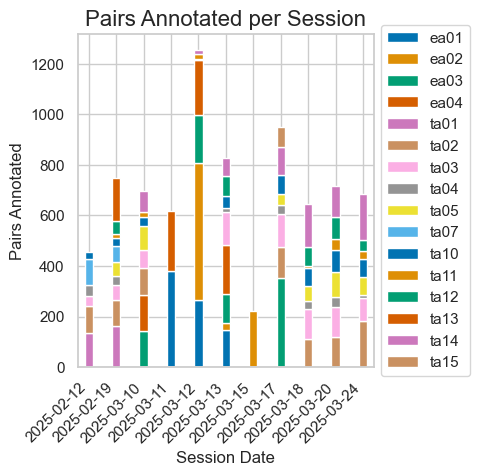

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
tmp = annos_clean[['userID', 'day']]
tmp = tmp.groupby(['day', 'userID']).size().unstack(fill_value=0)
color_palette = sns.color_palette("colorblind")
tmp.plot(kind='bar', stacked=True, figsize=(4, 5), width=0.3, color=color_palette)
plt.title('Pairs Annotated per Session', fontsize=16)
plt.xlabel('Session Date', fontsize=12)
plt.ylabel('Pairs Annotated', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.legend(loc='right', bbox_to_anchor=(1.35,0.5))
plt.show()

In [345]:
ea_processed['day'].value_counts()

2025-03-12    1153
2025-03-11     581
2025-03-13     462
2025-03-17     352
2025-03-10     265
2025-03-15     218
Name: day, dtype: int64

In [346]:
ta_processed['day'].value_counts()

2025-02-19    717
2025-03-17    444
2025-02-12    422
2025-03-20    401
2025-03-10    343
2025-03-13    268
2025-03-18    193
2025-03-12     22
Name: day, dtype: int64

In [347]:
ea_rows['userID'].value_counts()

ea03    798
ea01    794
ea02    793
ea04    793
Name: userID, dtype: int64

In [348]:
ta_rows['userID'].value_counts()

ta14    760
ta03    754
ta02    675
ta10    381
ta05    358
ta12    333
ta01    295
ta04    211
ta13    171
ta07    164
ta11    111
ta15     78
Name: userID, dtype: int64

#### DPO stats

In [6]:
tmp = pd.read_json('data/preferences_all.jsonl', lines=True)
tmp

train_split_idx = int(len(tmp) * 0.8)
dev_split_idx = int(len(tmp) * 0.9)
train_set, test_set, dev_set = tmp[:train_split_idx], tmp[train_split_idx:dev_split_idx], tmp[dev_split_idx:]
len(train_set), len(dev_set), len(test_set)

sum(base_dependencies.wcs(train_set['prompt']) + base_dependencies.wcs(train_set['chosen']) + base_dependencies.wcs(train_set['rejected']))


372687

In [7]:
sum(base_dependencies.wcs(dev_set['prompt']) + base_dependencies.wcs(dev_set['chosen']) + base_dependencies.wcs(dev_set['rejected']))


45857

In [8]:
sum(base_dependencies.wcs(test_set['prompt']) + base_dependencies.wcs(test_set['chosen']) + base_dependencies.wcs(test_set['rejected']))

45992

### Pilot Analysis

In [ ]:
#annos_latest = annos_raw.sort_values('timestamp').drop_duplicates(['userID', 'id'], keep='last').reset_index(drop=True)
#combined_target_anno = annos_latest[annos_latest['userID'].str.contains('ta')]
#combined_expert_anno = annos_latest[annos_latest['userID'].str.contains('ea')]
#combined_target_anno.head()



combined_target_lap = dpo_dependencies.length_and_perplexity(combined_target_anno)
combined_expert_lap = dpo_dependencies.length_and_perplexity(combined_expert_anno)

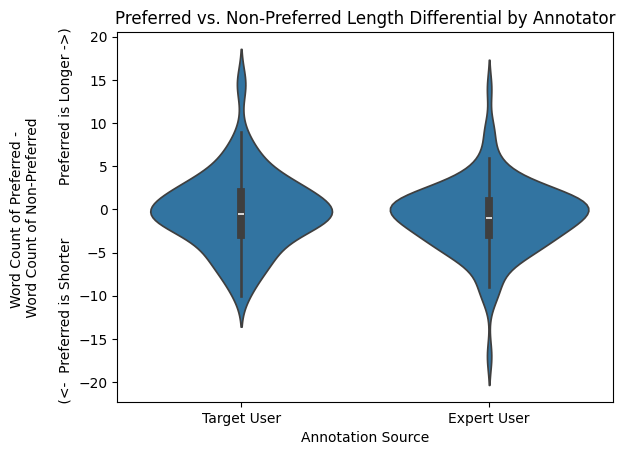

In [ ]:
dpo_dependencies.lap_violins(combined_target_lap, combined_expert_lap, 'wc_diff')

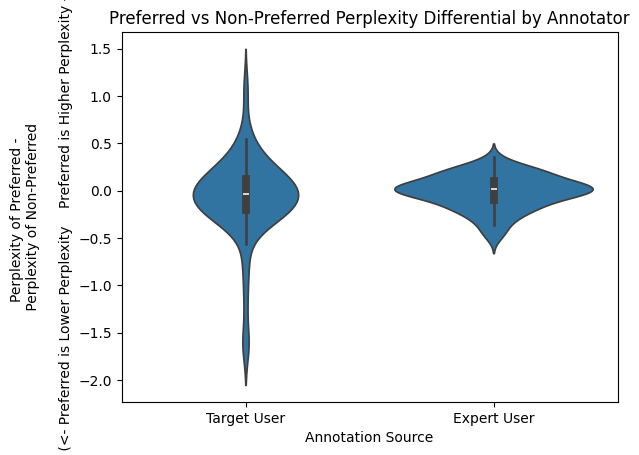

In [ ]:
dpo_dependencies.lap_violins(combined_target_lap, combined_expert_lap, 'p_diff')

In [ ]:
import sklearn
expert = combined_expert_lap.rename(columns={'preference':'exp_preference'})
target = combined_target_lap.rename(columns={'preference':'tar_preference'})
preference_set = pd.merge(left=target, right=expert, on=['id', 's1_len', 's2_len'],how='inner')[['s1_len', 's2_len', 'tar_preference', 'exp_preference']]
sklearn.metrics.cohen_kappa_score(preference_set['tar_preference'], preference_set['exp_preference'])

0.08675799086757996

In [ ]:
len(preference_set)

50

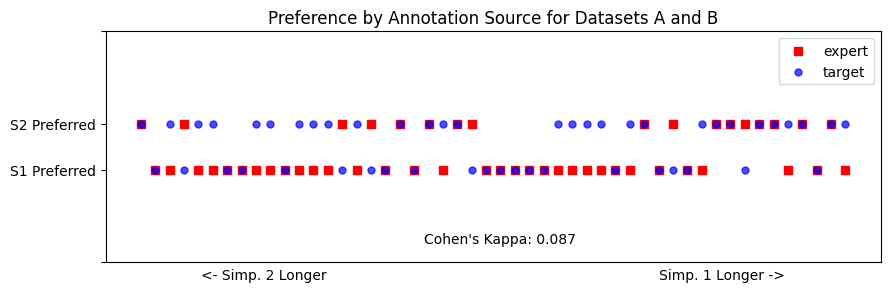

In [ ]:
import matplotlib.pyplot as plt

preference_set['wc_diff'] = preference_set['s1_len'] - preference_set['s2_len']
preference_set = preference_set.sort_values(by='wc_diff')
label_map = {'Vereinfachung 1': 0.95, 'Vereinfachung 2': 1.05}
y_tar = preference_set['tar_preference'].map(label_map)
y_exp = preference_set['exp_preference'].map(label_map)
x_positions = range(len(preference_set))
plt.figure(figsize=(10, 3))
plt.scatter(x_positions, y_exp, c='red', marker='s', label='expert')  # Red squares
plt.scatter(x_positions, y_tar, c='blue', marker='o', s=25, alpha=0.7, label='target')  # Blue circles
plt.xticks([])
plt.yticks([0.75, 0.95, 1.05, 1.25], ['', 'S1 Preferred', 'S2 Preferred', ''])
plt.xlabel('<- Simp. 2 Longer                                                                            Simp. 1 Longer ->')
plt.title('Preference by Annotation Source for Datasets A and B')
plt.text(len(preference_set) / 2, 0.8, "Cohen's Kappa: 0.087", ha='center', va='center', fontsize=10)
plt.legend()

plt.show()

In [ ]:
combined_expert_lap['preference'].value_counts()

Vereinfachung 1    64
Vereinfachung 2    36
Name: preference, dtype: int64